In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window

## **Exploratory Data Anlysis**

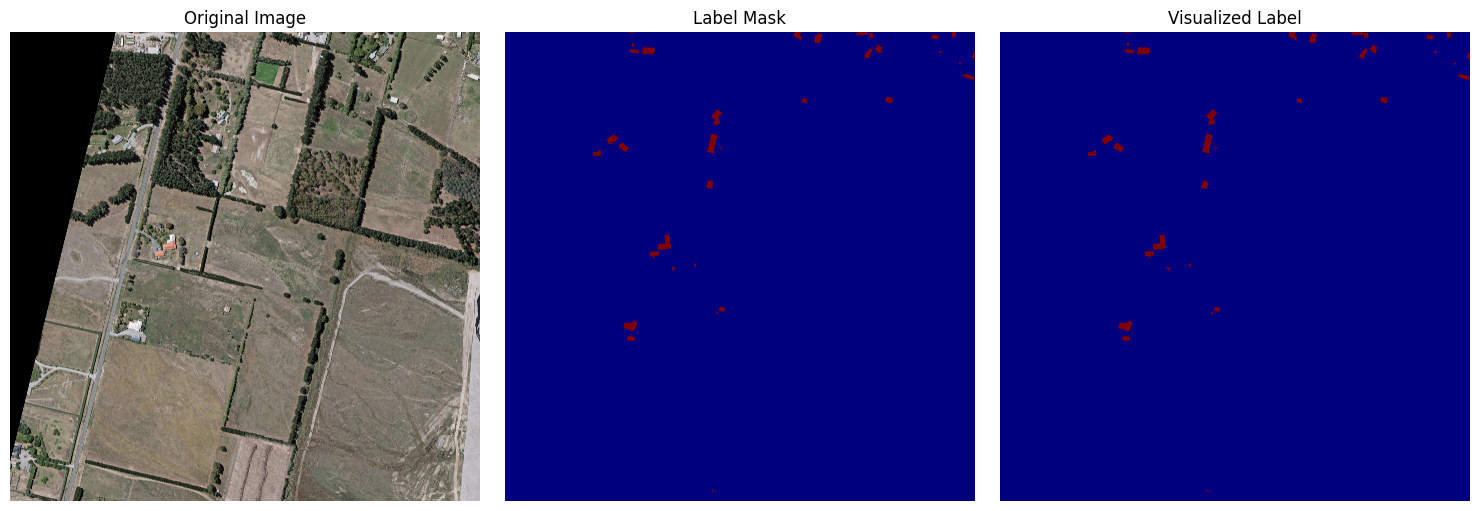

In [2]:
img_id = 10

with rasterio.open(f"data\\train\\image\\christchurch_{img_id}.tif") as src:
    img = src.read()
    
with rasterio.open(f"data\\train\\label\\christchurch_{img_id}.tif") as src:
    label = src.read()
    
with rasterio.open(f"data\\train\\label\\christchurch_{img_id}_vis.tif") as src:
    label_vis = src.read()
    

# Create figure
plt.figure(figsize=(15, 5))

# Plot 1: Original Image (RGB)
plt.subplot(1, 3, 1)
if img.shape[0] == 3:  # If RGB image
    plt.imshow(img.transpose(1, 2, 0))  # Convert from (C,H,W) to (H,W,C)
else:  # If single channel
    plt.imshow(img[0], cmap='gray')  # Show first band
plt.title("Original Image")
plt.axis('off')

# Plot 2: Label Mask
plt.subplot(1, 3, 2)
if len(label.shape) == 3:
    plt.imshow(label[0], cmap='jet')  # Show first band of label
else:
    plt.imshow(label, cmap='jet')
plt.title("Label Mask")
plt.axis('off')

# Plot 3: Visualized Label
plt.subplot(1, 3, 3)
if label_vis.shape[0] == 3:  # If RGB
    plt.imshow(label_vis.transpose(1, 2, 0))
else:  # If single channel
    plt.imshow(label_vis[0], cmap='jet')
plt.title("Visualized Label")
plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
print(img.shape, label.shape, label_vis.shape)

(3, 10000, 10000) (1, 10000, 10000) (1, 10000, 10000)


In [4]:
img.min(), img.max()

(np.uint8(0), np.uint8(255))

## **Patch Process Test**

In [5]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from src.preprocess import MultiFileRoofDataset
from torchvision import transforms
import torch.nn.functional as F


In [6]:

transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = MultiFileRoofDataset(
    img_dir="data/train/image",
    mask_dir="data/train/label",
    patch_size=512,
    stride=256,
    augment=True
)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

val_data = MultiFileRoofDataset(
    img_dir="data/val/image",
    mask_dir="data/val/label",
    patch_size=512,
    stride=256,
    augment=True
)
train_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=16,
    shuffle=True,
    num_workers=4
)


In [7]:
INPUT_SIZE = 512

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(CNN, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)  # (1, 16, 512, 512)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # (1, 32, 512, 512)
        self.pool = nn.MaxPool2d(2, 2)  # (1, 32, 256, 256)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # Down to 128x128

        # Bottleneck
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Up to 256x256
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # Up to 512x512
        self.conv6 = nn.Conv2d(16, 8, kernel_size=3, padding=1)

        # Output Layer (Same size as input)
        self.final_conv = nn.Conv2d(8, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        x1 = F.relu(self.conv1(x))
        x2 = self.pool(F.relu(self.conv2(x1)))

        x3 = F.relu(self.conv3(x2))
        x4 = self.pool2(F.relu(x3))

        # Bottleneck
        x5 = F.relu(self.conv4(x4))

        # Decoding
        x6 = F.relu(self.upconv1(x5))  # Up to 256x256
        x6 = F.relu(self.conv5(x6))

        x7 = F.relu(self.upconv2(x6))  # Up to 512x512
        x7 = F.relu(self.conv6(x7))

        # Final Output (Mask)
        x_out = torch.sigmoid(self.final_conv(x7))  # Binary mask output
        return x_out



In [13]:
from torchsummary import summary

# Example usage
model = CNN()
print(f"Summary: {summary(model, input_size=(3,512,512))}")
sample_input = torch.randn(1, 3, 512, 512)  # Batch size 1, RGB image
output = model(sample_input)
print(output.shape)  # Should be (1, 1, 512, 512)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             448
            Conv2d-2         [-1, 32, 512, 512]           4,640
         MaxPool2d-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          18,496
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
   ConvTranspose2d-7         [-1, 64, 256, 256]          32,832
            Conv2d-8         [-1, 32, 256, 256]          18,464
   ConvTranspose2d-9         [-1, 16, 512, 512]           2,064
           Conv2d-10          [-1, 8, 512, 512]           1,160
           Conv2d-11          [-1, 1, 512, 512]               9
Total params: 151,969
Trainable params: 151,969
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/

In [16]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-1, device="cpu"):
    """
    Train the CNN model for image segmentation.

    Parameters:
    - model: PyTorch model (CNN)
    - train_loader: DataLoader for training set
    - val_loader: DataLoader for validation set
    - num_epochs: Number of epochs
    - learning_rate: Initial learning rate
    - device: "cuda" or "cpu"

    Returns:
    - Trained model
    """
    # Move model to GPU/CPU
    model.to(device)
    
    # Loss function: Binary Cross-Entropy for binary segmentation
    criterion = nn.BCELoss()  # Use nn.CrossEntropyLoss() for multi-class masks

    # Optimizer: Adam with weight decay (L2 regularization)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Learning Rate Scheduler (optional)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Training Loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0
        # Initialize tqdm progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=True)

        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)  # Move to GPU

            optimizer.zero_grad()  # Reset gradients
            
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, masks)  # Compute loss

            loss.backward()  # Backpropagation
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()  # Update weights

            epoch_loss += loss.item()
            
            # Update tqdm description with current loss
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        # Adjust learning rate
        scheduler.step()

        # Print epoch stats
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

        # Validation (Optional)
        if val_loader:
            validate_model(model, val_loader, criterion, device)

    return model

@torch.no_grad()
def validate_model(model, val_loader, criterion, device="cpu"):
    """
    Validate model on the validation dataset.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0

    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}")


In [17]:
# Assuming you have a DataLoader for training & validation
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128)

# Create model instance
model = CNN()

# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=1, learning_rate=1e-3)


Epoch [1/1]:   0%|          | 5/9515 [02:46<87:49:17, 33.24s/it, loss=0.6428]


KeyboardInterrupt: 